In [148]:
import numpy as np
import pandas as pd
import os
import pathlib
import scanpy as sc
from anndata import AnnData
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [149]:
path_test_csv = '/home/matthieu.bernard/Documents/IF_to_IMC/data/15_measurements.txt'

In [150]:
df = pd.read_csv(path_test_csv,sep='\t')

# Get rid of useless columns
df = df.drop(columns=['Image','Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI'])

def is_nucleus_col(col):
    pass

for col in df.columns:
    if re.split(r'[:,/]',col)[0] == 'Nucleus' or re.split(r'[:,/]',col)[0] == 'Cytoplasm' or re.split(r'[:,/]',col)[0] == 'Membrane':
        df=df.drop(columns=[col])
        pass

df = df.dropna()

coords = df[['Centroid X µm', 'Centroid Y µm']]
df = df.drop(columns=['Centroid X µm','Centroid Y µm'])

coords['Centroid X µm']

0        13991.4
1        14012.7
2        13951.5
3        13970.8
4        13959.1
          ...   
36811    16154.8
36812    15258.6
36813    15364.3
36814    15476.2
36815    16469.9
Name: Centroid X µm, Length: 36814, dtype: float64

/home/matthieu.bernard/miniconda3/envs/env/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


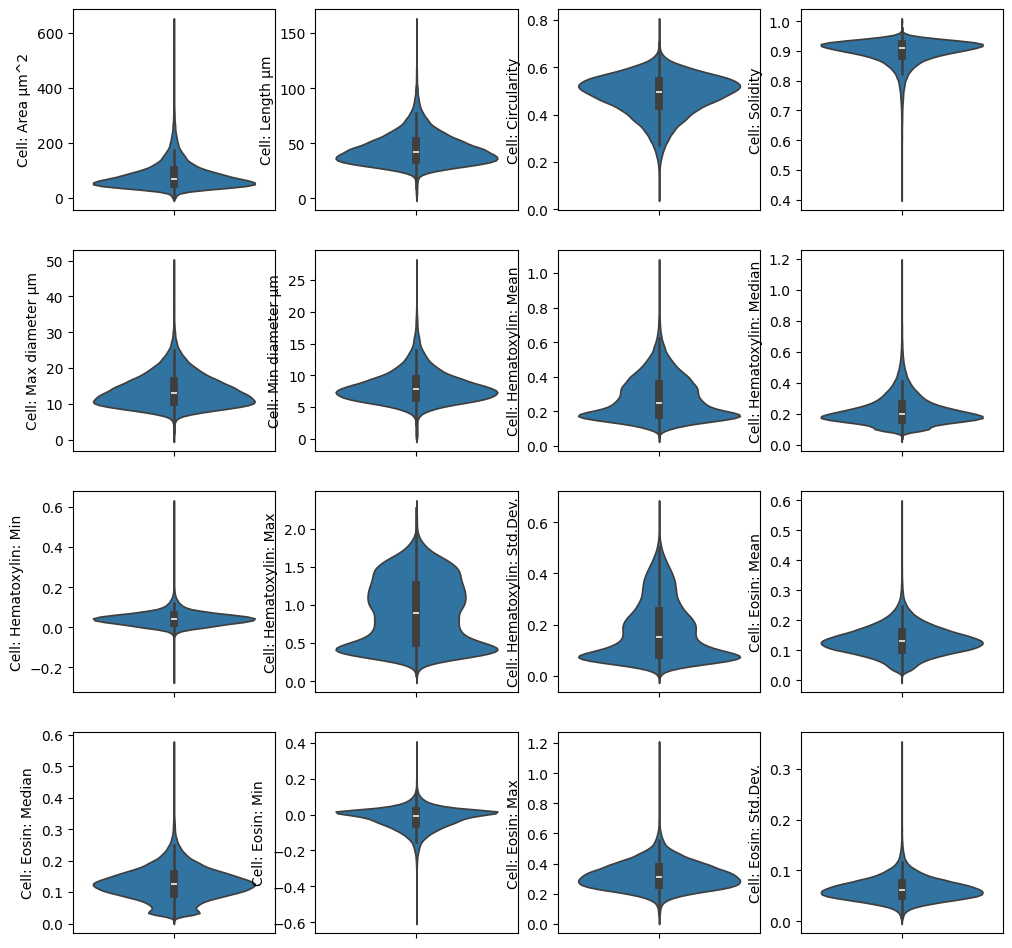

AnnData object with n_obs × n_vars = 36814 × 16
    obs: 'X', 'Y'

In [171]:
adata = AnnData(df)
adata.obs['X'] = pd.Categorical(coords['Centroid X µm'])
adata.obs['Y'] = pd.Categorical(coords['Centroid Y µm'])

fig, axs = plt.subplots(nrows=4, ncols=4,figsize=(12, 12))
axs = axs.flatten()
for i,col in enumerate(df.columns):
    sns.violinplot(data=df, y=col, ax=axs[i])
plt.show()
adata

In [174]:
std_multiplier = 2

stds = [adata.X[:,i].std() for i in range(adata.n_vars)]
means = [adata.X[:,i].mean() for i in range(adata.n_vars)]
upper_thresholds = np.add(means,np.multiply(stds,std_multiplier))
lower_thresholds = np.subtract(means,np.multiply(stds,std_multiplier))
mask_matrix = (adata.X < upper_thresholds) & (adata.X > lower_thresholds)

cell_mask = mask_matrix.all(axis=1)
adata=adata[cell_mask,:]

adata

View of AnnData object with n_obs × n_vars = 24623 × 16
    obs: 'X', 'Y'

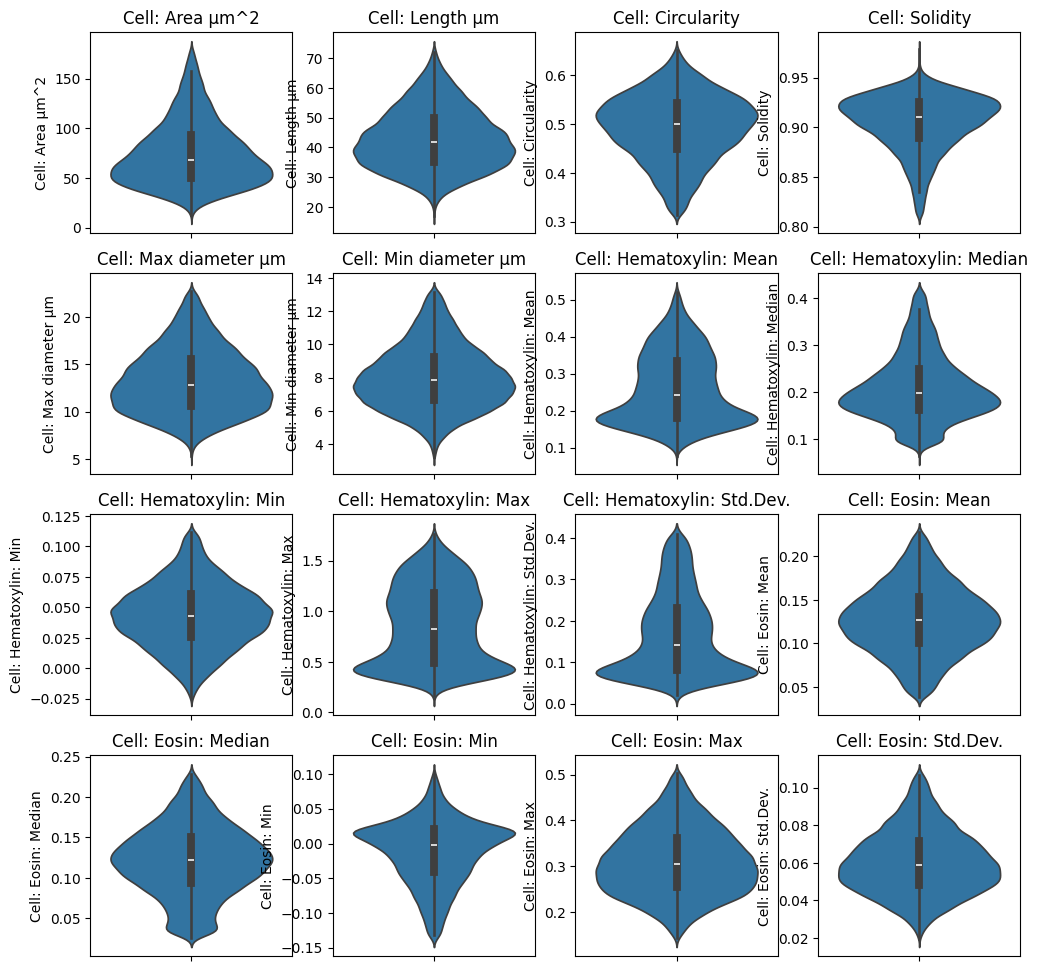

View of AnnData object with n_obs × n_vars = 24623 × 16
    obs: 'X', 'Y'

In [175]:

fig, axs = plt.subplots(nrows=4, ncols=4,figsize=(12, 12))
axs = axs.flatten()

df_from_adata = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)

for i,col in enumerate(adata.var_names):
    sns.violinplot(data=df_from_adata, y=col, ax=axs[i])  # if grouped
    axs[i].set_title(col)
plt.show()
adata

In [176]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.scale(adata)

/home/matthieu.bernard/miniconda3/envs/env/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


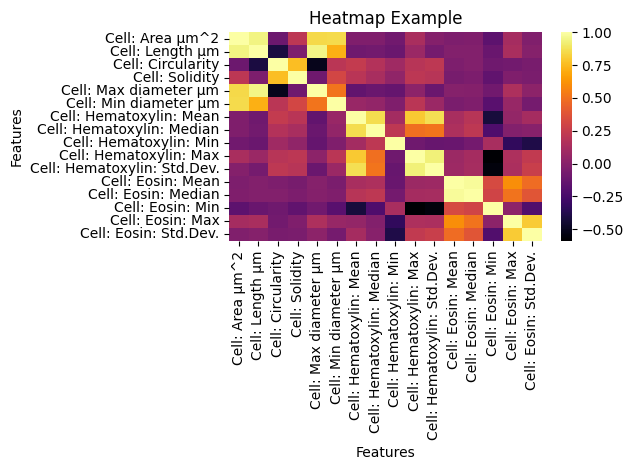

In [177]:
corr = df_from_adata.corr()

sns.heatmap(corr, cmap='inferno', annot=False    )
plt.title("Heatmap Example")
plt.xlabel("Features")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

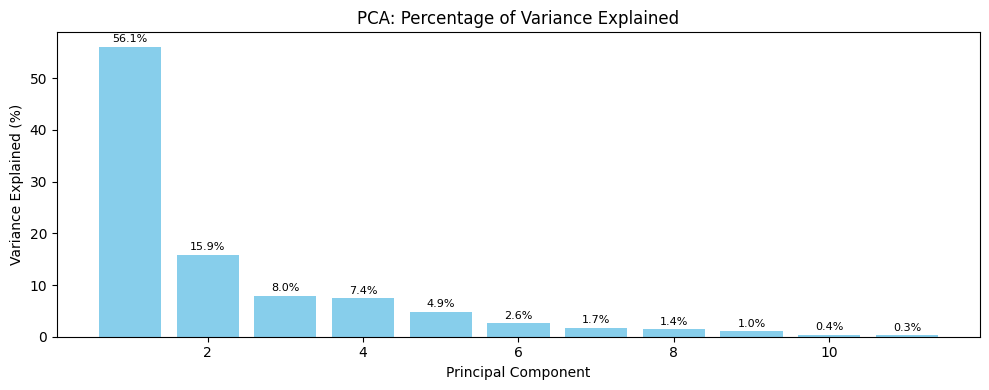

In [178]:
sc.tl.pca(adata, n_comps=11)

explained = adata.uns['pca']['variance_ratio']

plt.figure(figsize=(10, 4))
plt.bar(range(1, len(explained)+1), explained * 100, color='skyblue')
for i, v in enumerate(explained):
    plt.text(i + 1, 100*v + 0.5, f"{100*v:.1f}%", ha='center', va='bottom', fontsize=8)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('PCA: Percentage of Variance Explained')
plt.tight_layout()
plt.show()

In [179]:
loadings = adata.varm['PCs']
loading_df = pd.DataFrame(
    loadings,
    index=adata.var_names,
    columns=[f'PC{i+1}' for i in range(loadings.shape[1])]
)

loading_df

PC1       PC2       PC3       PC4       PC5  \
Cell: Area µm^2             -0.298862 -0.173855 -0.205138 -0.177181 -0.082907   
Cell: Length µm              0.263189  0.249874  0.288068  0.203133  0.063397   
Cell: Circularity            0.294820 -0.000689 -0.220395  0.117966  0.302033   
Cell: Solidity               0.311604  0.088801 -0.053400  0.155225  0.232194   
Cell: Max diameter µm        0.183353  0.319207  0.527828  0.182918 -0.122014   
Cell: Min diameter µm        0.228190 -0.107957 -0.470131  0.086315  0.436549   
Cell: Hematoxylin: Mean      0.268445 -0.320766  0.003024  0.076609 -0.271576   
Cell: Hematoxylin: Median    0.268877 -0.184956 -0.071372  0.164707 -0.320206   
Cell: Hematoxylin: Min       0.167716  0.061855 -0.280554  0.586028 -0.239443   
Cell: Hematoxylin: Max       0.218466 -0.422602  0.121868 -0.063741 -0.125408   
Cell: Hematoxylin: Std.Dev.  0.213057 -0.433726  0.133915 -0.094632 -0.140904   
Cell: Eosin: Mean            0.278068  0.158465 -0.136806 -0.354062 -0.216603   
Cell: Eosin: Median          0.265850  0.130323 -0.160319 -0.357339 -0.304876   
Cell: Eosin: Min             0.011800  0.468685 -0.375903 -0.081369 -0.359207   
Cell: Eosin: Max             0.283831  0.119896  0.038560 -0.319708  0.164056   
Cell: Eosin: Std.Dev.        0.278217  0.046161  0.141695 -0.311600  0.271104   

                                  PC6       PC7       PC8       PC9      PC10  \
Cell: Area µm^2              0.160748  0.077055 -0.166072  0.199691 -0.012059   
Cell: Length µm             -0.162865 -0.076207  0.246118 -0.393777 -0.034131   
Cell: Circularity           -0.108806  0.024122 -0.140317  0.590549  0.008596   
Cell: Solidity              -0.121873 -0.003931 -0.054700  0.349621 -0.015319   
Cell: Max diameter µm       -0.057277 -0.015311 -0.033237  0.275020  0.040507   
Cell: Min diameter µm       -0.205215 -0.044645  0.267242 -0.328254  0.010308   
Cell: Hematoxylin: Mean     -0.115383  0.199275 -0.094606 -0.064906 -0.130977   
Cell: Hematoxylin: Median   -0.111851  0.705960 -0.063992 -0.088693  0.101614   
Cell: Hematoxylin: Min       0.628751 -0.260933 -0.115868 -0.085262 -0.036830   
Cell: Hematoxylin: Max      -0.099005 -0.433535 -0.074617  0.017975  0.298688   
Cell: Hematoxylin: Std.Dev. -0.162356 -0.360026 -0.127713 -0.024214 -0.255381   
Cell: Eosin: Mean            0.149392 -0.047526  0.284813  0.102287 -0.017539   
Cell: Eosin: Median          0.146191 -0.036765  0.467926  0.165014 -0.024415   
Cell: Eosin: Min            -0.467466 -0.202514 -0.452223 -0.126081 -0.113394   
Cell: Eosin: Max             0.237455  0.048136 -0.391129 -0.221157  0.650133   
Cell: Eosin: Std.Dev.        0.315653  0.121421 -0.332765 -0.167143 -0.613945   

                                 PC11  
Cell: Area µm^2             -0.020261  
Cell: Length µm              0.080954  
Cell: Circularity           -0.004566  
Cell: Solidity               0.052634  
Cell: Max diameter µm       -0.146936  
Cell: Min diameter µm       -0.102229  
Cell: Hematoxylin: Mean     -0.320901  
Cell: Hematoxylin: Median    0.232724  
Cell: Hematoxylin: Min      -0.019103  
Cell: Hematoxylin: Max       0.640996  
Cell: Hematoxylin: Std.Dev. -0.470406  
Cell: Eosin: Mean            0.010793  
Cell: Eosin: Median         -0.025784  
Cell: Eosin: Min             0.081870  
Cell: Eosin: Max            -0.285032  
Cell: Eosin: Std.Dev.        0.282519

In [180]:
for i in range(1,12):
    top_morph_pc1 = loading_df['PC'+str(i)].abs().sort_values(ascending=False).head(7)
    print('\n[PC'+str(i)+']')
    print(top_morph_pc1, sep='')


[PC1]
Cell: Solidity               0.311604
Cell: Area µm^2              0.298862
Cell: Circularity            0.294820
Cell: Eosin: Max             0.283831
Cell: Eosin: Std.Dev.        0.278217
Cell: Eosin: Mean            0.278068
Cell: Hematoxylin: Median    0.268877
Name: PC1, dtype: float64

[PC2]
Cell: Eosin: Min               0.468685
Cell: Hematoxylin: Std.Dev.    0.433726
Cell: Hematoxylin: Max         0.422602
Cell: Hematoxylin: Mean        0.320766
Cell: Max diameter µm          0.319207
Cell: Length µm                0.249874
Cell: Hematoxylin: Median      0.184956
Name: PC2, dtype: float64

[PC3]
Cell: Max diameter µm     0.527828
Cell: Min diameter µm     0.470131
Cell: Eosin: Min          0.375903
Cell: Length µm           0.288068
Cell: Hematoxylin: Min    0.280554
Cell: Circularity         0.220395
Cell: Area µm^2           0.205138
Name: PC3, dtype: float64

[PC4]
Cell: Hematoxylin: Min    0.586028
Cell: Eosin: Median       0.357339
Cell: Eosin: Mean         0.35406

In [181]:
# Neighborhood graph
sc.pp.neighbors(adata, n_neighbors=6, n_pcs=6)

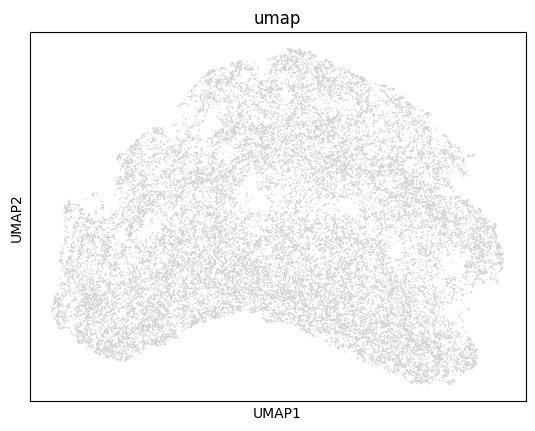

In [182]:

sc.tl.umap(adata,spread = 2, min_dist = 0.1)
sc.pl.umap(adata, title=f"umap")

In [183]:
sc.tl.leiden(adata, resolution=0.5)

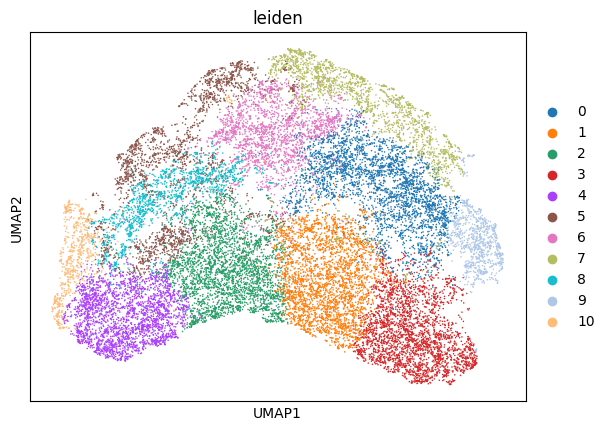

In [184]:
sc.pl.umap(adata, color='leiden')

In [224]:
sc.tl.louvain(adata, resolution=0.3)

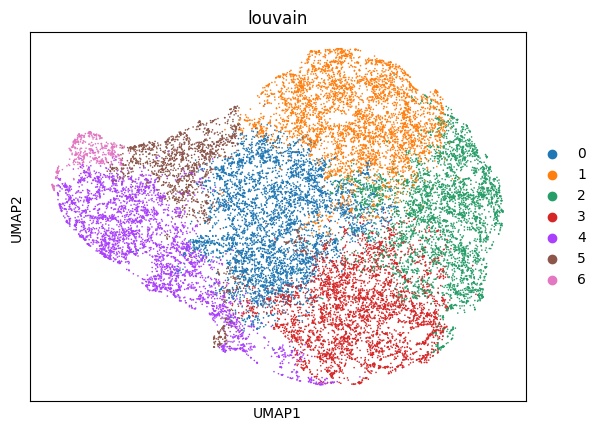

In [225]:
sc.pl.umap(adata, color='louvain')

<Axes: xlabel='X', ylabel='Y'>

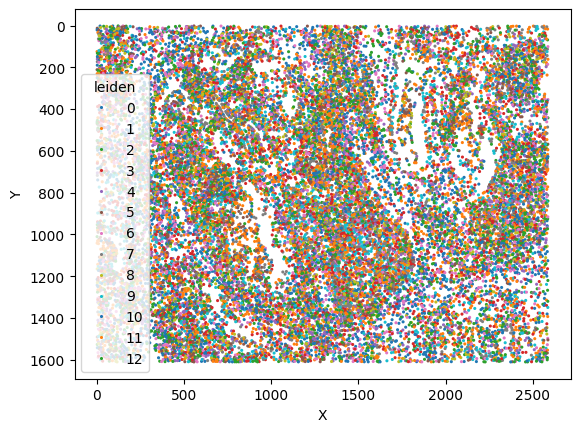

In [226]:
sns.scatterplot(
    x=adata.obs['X'], y=adata.obs['Y'],
    hue=adata.obs['leiden'],
    palette='tab10', s=5, linewidth=0
)

<Axes: xlabel='X', ylabel='Y'>

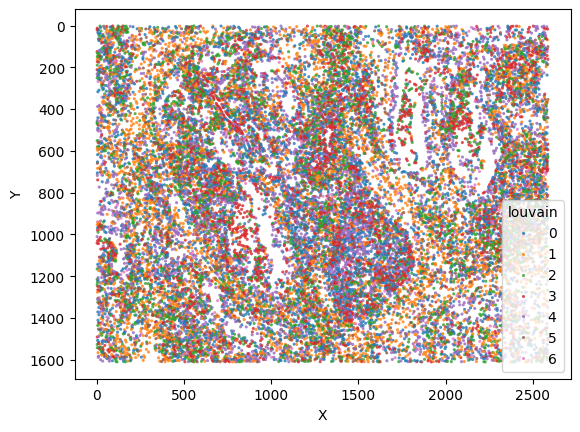

In [245]:
sns.scatterplot(
    x=adata.obs['X'], y=adata.obs['Y'],
    hue=adata.obs['louvain'],
    palette='tab10', s=5, linewidth=0, alpha=0.8
)

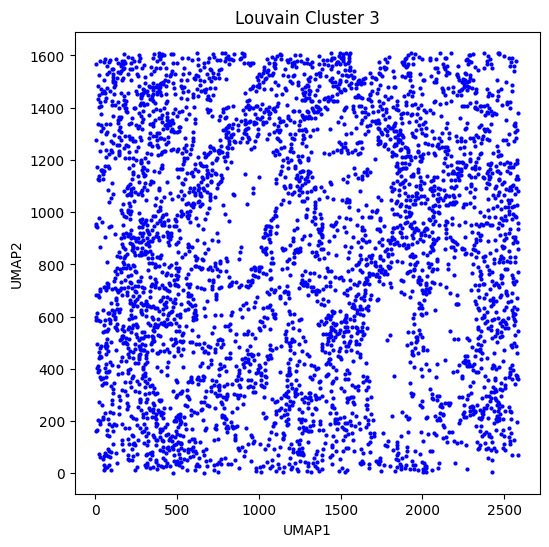

In [250]:
mask = adata.obs['louvain'] == '1'#(adata.obs['louvain'] == '3') | (adata.obs['louvain'] == '4') 
x = adata.obs['X'][mask]
y = adata.obs['Y'][mask]

plt.figure(figsize=(6,6))
plt.scatter(x, y, s=4, c='blue')
plt.title('Louvain Cluster 3')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

<h2>IMC

In [194]:
path_test_csv = '/home/matthieu.bernard/Documents/IF_to_IMC/data/15_meas_imc_Ir191.txt'

In [195]:
df = pd.read_csv(path_test_csv,sep='\t')

# Get rid of useless columns
df = df.drop(columns=['Image','Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI'])

def is_nucleus_col(col):
    pass

for col in df.columns:
    if re.split(r'[:,/]',col)[0] == 'Nucleus' or re.split(r'[:,/]',col)[0] == 'Cytoplasm' or re.split(r'[:,/]',col)[0] == 'Membrane':
        df=df.drop(columns=[col])
        pass

df = df.dropna()

coords = df[['Centroid X µm', 'Centroid Y µm']]
df = df.drop(columns=['Centroid X µm','Centroid Y µm'])

coords['Centroid X µm']

0         12.23
1         18.63
2         34.55
3         39.39
4         45.59
          ...  
28362     49.84
28363    909.80
28364    732.73
28365    839.13
28366    847.66
Name: Centroid X µm, Length: 28367, dtype: float64

/home/matthieu.bernard/miniconda3/envs/env/lib/python3.13/site-packages/anndata/utils.py:311: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/home/matthieu.bernard/miniconda3/envs/env/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


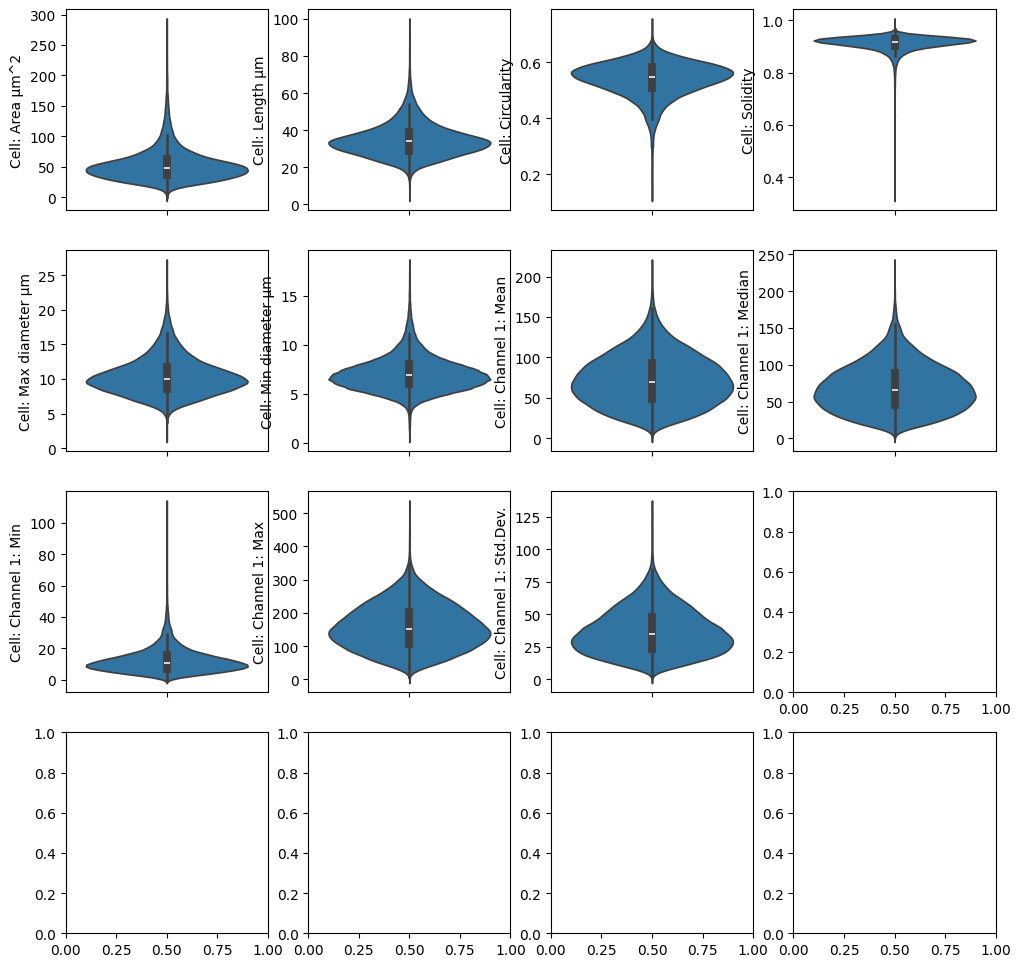

AnnData object with n_obs × n_vars = 28367 × 11
    obs: 'X', 'Y'

In [196]:
adata = AnnData(df)
adata.obs['X'] = pd.Categorical(coords['Centroid X µm'])
adata.obs['Y'] = pd.Categorical(coords['Centroid Y µm'])

fig, axs = plt.subplots(nrows=4, ncols=4,figsize=(12, 12))
axs = axs.flatten()
for i,col in enumerate(df.columns):
    sns.violinplot(data=df, y=col, ax=axs[i])
plt.show()
adata

In [197]:
std_multiplier = 2

stds = [adata.X[:,i].std() for i in range(adata.n_vars)]
means = [adata.X[:,i].mean() for i in range(adata.n_vars)]
upper_thresholds = np.add(means,np.multiply(stds,std_multiplier))
lower_thresholds = np.subtract(means,np.multiply(stds,std_multiplier))
mask_matrix = (adata.X < upper_thresholds) & (adata.X > lower_thresholds)

cell_mask = mask_matrix.all(axis=1)
adata=adata[cell_mask,:]

adata

View of AnnData object with n_obs × n_vars = 22258 × 11
    obs: 'X', 'Y'

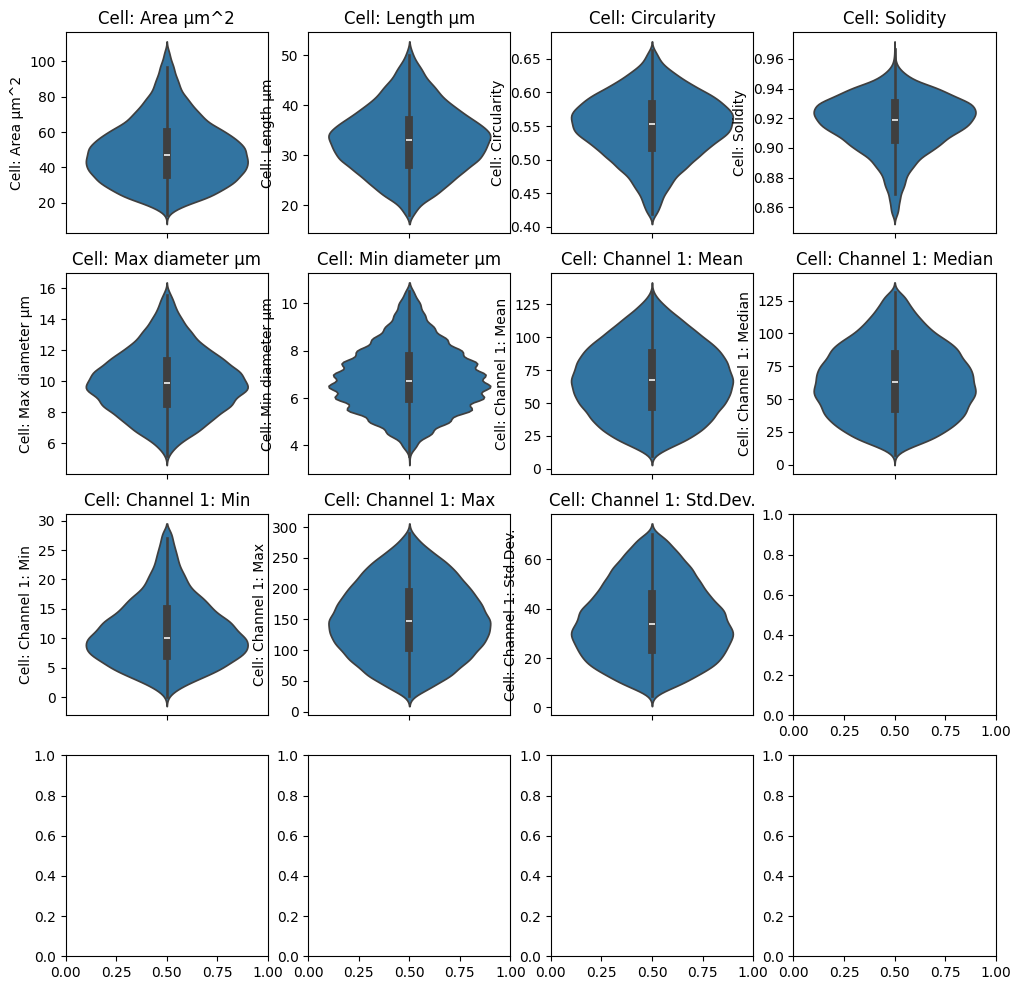

View of AnnData object with n_obs × n_vars = 22258 × 11
    obs: 'X', 'Y'

In [198]:

fig, axs = plt.subplots(nrows=4, ncols=4,figsize=(12, 12))
axs = axs.flatten()

df_from_adata = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)

for i,col in enumerate(adata.var_names):
    sns.violinplot(data=df_from_adata, y=col, ax=axs[i])  # if grouped
    axs[i].set_title(col)
plt.show()
adata

In [199]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.scale(adata)

/home/matthieu.bernard/miniconda3/envs/env/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


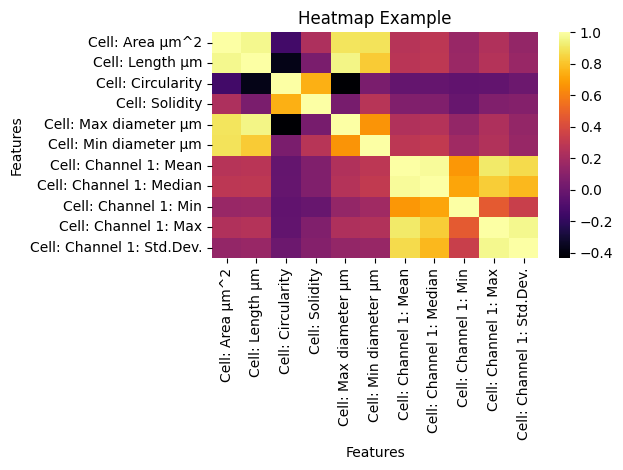

In [200]:
corr = df_from_adata.corr()

sns.heatmap(corr, cmap='inferno', annot=False    )
plt.title("Heatmap Example")
plt.xlabel("Features")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


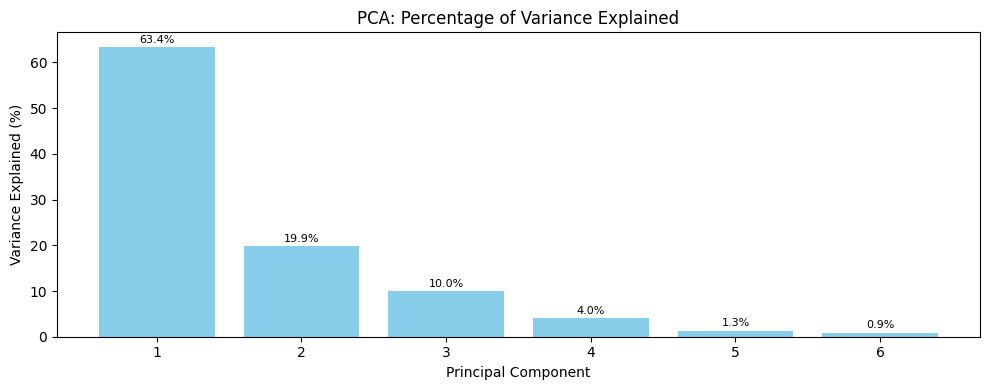

In [202]:
sc.tl.pca(adata, n_comps=6)

explained = adata.uns['pca']['variance_ratio']

plt.figure(figsize=(10, 4))
plt.bar(range(1, len(explained)+1), explained * 100, color='skyblue')
for i, v in enumerate(explained):
    plt.text(i + 1, 100*v + 0.5, f"{100*v:.1f}%", ha='center', va='bottom', fontsize=8)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('PCA: Percentage of Variance Explained')
plt.tight_layout()
plt.show()

In [211]:
sc.pp.neighbors(adata, n_neighbors=6, n_pcs=4)

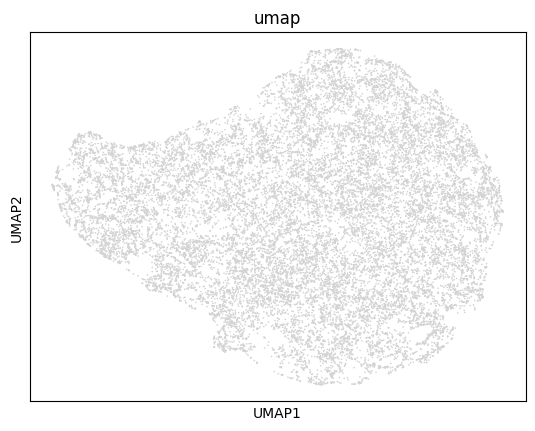

In [212]:

sc.tl.umap(adata,spread = 2, min_dist = 0.1)
sc.pl.umap(adata, title=f"umap")

In [213]:
sc.tl.leiden(adata, resolution=0.5)

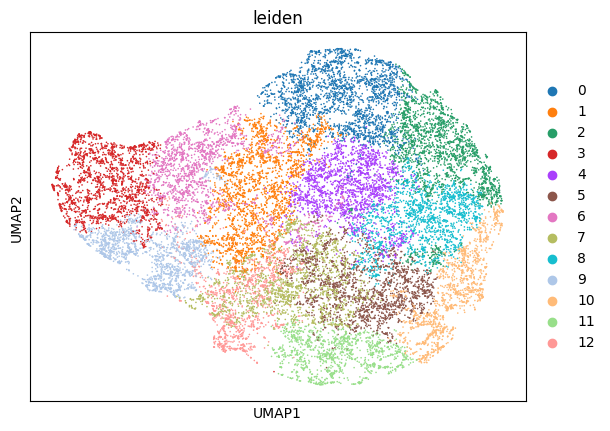

In [214]:
sc.pl.umap(adata, color='leiden')

In [215]:
sc.tl.louvain(adata, resolution=0.5)

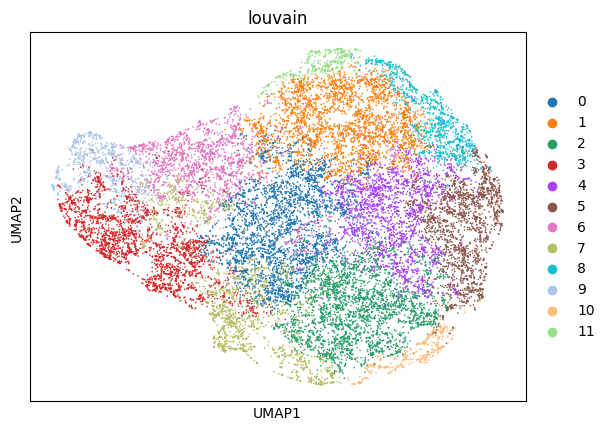

In [216]:
sc.pl.umap(adata, color='louvain')

<Axes: xlabel='X', ylabel='Y'>

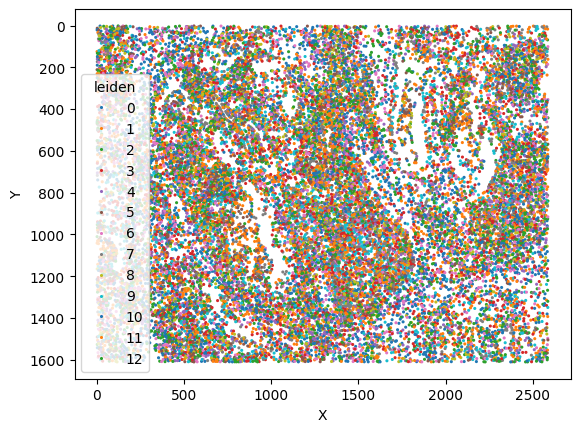

In [217]:
sns.scatterplot(
    x=adata.obs['X'], y=adata.obs['Y'],
    hue=adata.obs['leiden'],
    palette='tab10', s=5, linewidth=0
)

<Axes: xlabel='X', ylabel='Y'>

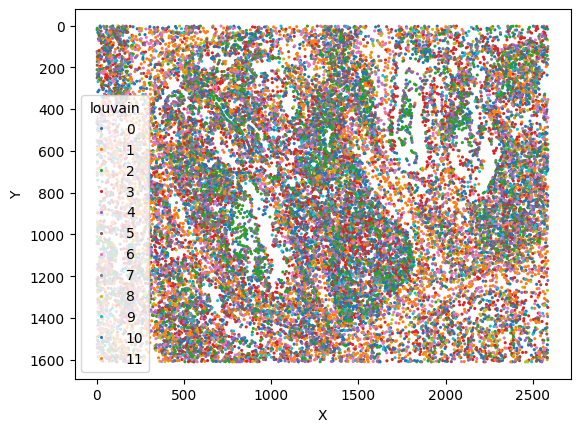

In [218]:
sns.scatterplot(
    x=adata.obs['X'], y=adata.obs['Y'],
    hue=adata.obs['louvain'],
    palette='tab10', s=5, linewidth=0
)